<a href="https://colab.research.google.com/github/rp3311/rtf-lab-1/blob/master/Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Первичная инициализация

In [ ]:
!pip install tensorflow_addons
import os
import time
import glob
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_addons as tfa

from skimage import measure
from skimage.io import imread, imsave, imshow
from skimage.transform import resize
from skimage.filters import gaussian
from skimage.morphology import dilation, disk
from skimage.draw import polygon, polygon_perimeter
from skimage.color import rgba2rgb

print(f'Tensorflow version {tf.__version__}')
print(f'GPU is {"ON" if tf.config.list_physical_devices("GPU") else "OFF" }')

from google.colab import drive
drive.mount('/content/drive')

CLASSES = 2
COLORS = ['red','black']
SAMPLE_SIZE = (256, 256)
OUTPUT_SIZE = (1080, 1920)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 15.1 MB/s 
Tensorflow version 2.9.2
GPU is ON
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Функции подготовки массива для обучения

In [ ]:
def load_images(image, mask):
    image = tf.io.read_file(image)
    image = tf.io.decode_jpeg(image)
    print(image)
    image = tfa.image.gaussian_filter2d(image)
    image = tf.image.resize(image, OUTPUT_SIZE)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = image / 255.0
    
    mask = tf.io.read_file(mask)
    mask = tf.io.decode_png(mask)
    mask = tf.image.resize(mask, OUTPUT_SIZE)
    mask = tf.image.convert_image_dtype(mask, tf.float32)
    
    masks = []
    
    for i in range(CLASSES):
        masks.append(tf.where(tf.equal(mask, float(i)), 1.0, 0.0))
    
    masks = tf.stack(masks, axis=2)
    masks = tf.reshape(masks, OUTPUT_SIZE + (CLASSES,))

    return image, masks

def augmentate_images(image, masks):   
    random_crop = tf.random.uniform((), 0.3, 1)
    image = tf.image.central_crop(image, random_crop)
    masks = tf.image.central_crop(masks, random_crop)
    
    random_flip = tf.random.uniform((), 0, 1)    
    if random_flip >= 0.5:
        image = tf.image.flip_left_right(image)
        masks = tf.image.flip_left_right(masks)
    
    image = tf.image.resize(image, SAMPLE_SIZE)
    masks = tf.image.resize(masks, SAMPLE_SIZE)
    
    return image, masks

In [ ]:
images = sorted(glob.glob('/content/drive/MyDrive/GRYAZY/DB/imgNmask/*/img/*.jpg'))
masks = sorted(glob.glob('/content/drive/MyDrive/GRYAZY/DB/imgNmask/*/masks_machine/*.png'))

print(len(images))
print(len(masks))

if len(images) != len(masks):
  raise NameError('Количество фото не равно количеству масок!')

images_dataset = tf.data.Dataset.from_tensor_slices(images)
masks_dataset = tf.data.Dataset.from_tensor_slices(masks)

dataset = tf.data.Dataset.zip((images_dataset, masks_dataset))

dataset = dataset.map(load_images, num_parallel_calls=tf.data.AUTOTUNE)
dataset = dataset.repeat(60)
dataset = dataset.map(augmentate_images, num_parallel_calls=tf.data.AUTOTUNE)



train_dataset = dataset.take(310).cache()
test_dataset = dataset.skip(310).take(100).cache()
 
train_dataset = train_dataset.batch(16)
test_dataset = test_dataset.batch(16)

410
410
Tensor("DecodeJpeg:0", shape=(None, None, None), dtype=uint8)


## Вывод 5 примеров датасета

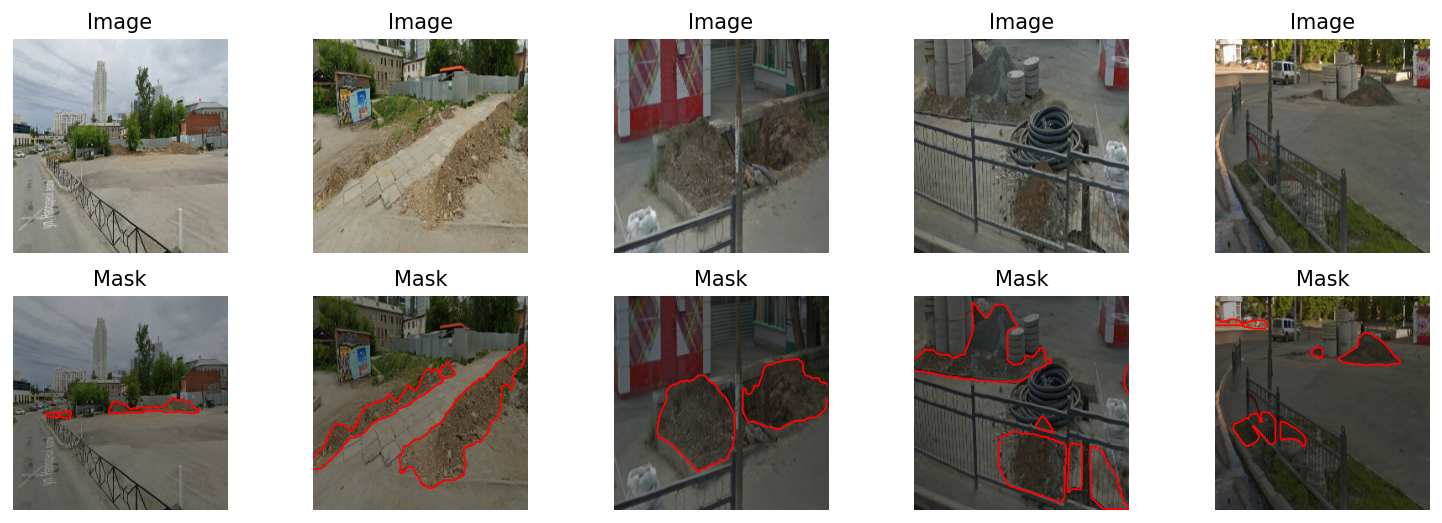

In [ ]:
images_and_masks = list(dataset.take(5))

fig, ax = plt.subplots(nrows = 2, ncols = 5, figsize=(15, 5), dpi=125)

for i, (image, masks) in enumerate(images_and_masks):
    ax[0, i].set_title('Image')
    ax[0, i].set_axis_off()
    ax[0, i].imshow(image)
        
    ax[1, i].set_title('Mask')
    ax[1, i].set_axis_off()    
    ax[1, i].imshow(image/1.5)
   
    for channel in range(CLASSES):
        contours = measure.find_contours(np.array(masks[:,:,channel]))
        for contour in contours:
            ax[1, i].plot(contour[:, 1], contour[:, 0], linewidth=1, color=COLORS[channel])

plt.show()
plt.close()

## Настройка блоков модели

In [ ]:
def input_layer():
    return tf.keras.layers.Input(shape=SAMPLE_SIZE + (3,))

def downsample_block(filters, size, batch_norm=True):
    initializer = tf.keras.initializers.GlorotNormal()

    result = tf.keras.Sequential()
    
    result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if batch_norm:
        result.add(tf.keras.layers.BatchNormalization())
    
    result.add(tf.keras.layers.LeakyReLU())
    return result

def upsample_block(filters, size, dropout=False):
    initializer = tf.keras.initializers.GlorotNormal()

    result = tf.keras.Sequential()
    
    result.add(
        tf.keras.layers.Conv2DTranspose(filters, size, strides=2, padding='same',
                                        kernel_initializer=initializer, use_bias=False))

    result.add(tf.keras.layers.BatchNormalization())
    
    if dropout:
        result.add(tf.keras.layers.Dropout(0.25))
    
    result.add(tf.keras.layers.ReLU())
    return result

def output_layer(size):
    initializer = tf.keras.initializers.GlorotNormal()
    return tf.keras.layers.Conv2DTranspose(CLASSES, size, strides=2, padding='same',
                                           kernel_initializer=initializer, activation='sigmoid')

## Создание U-NET подобной архитектуры

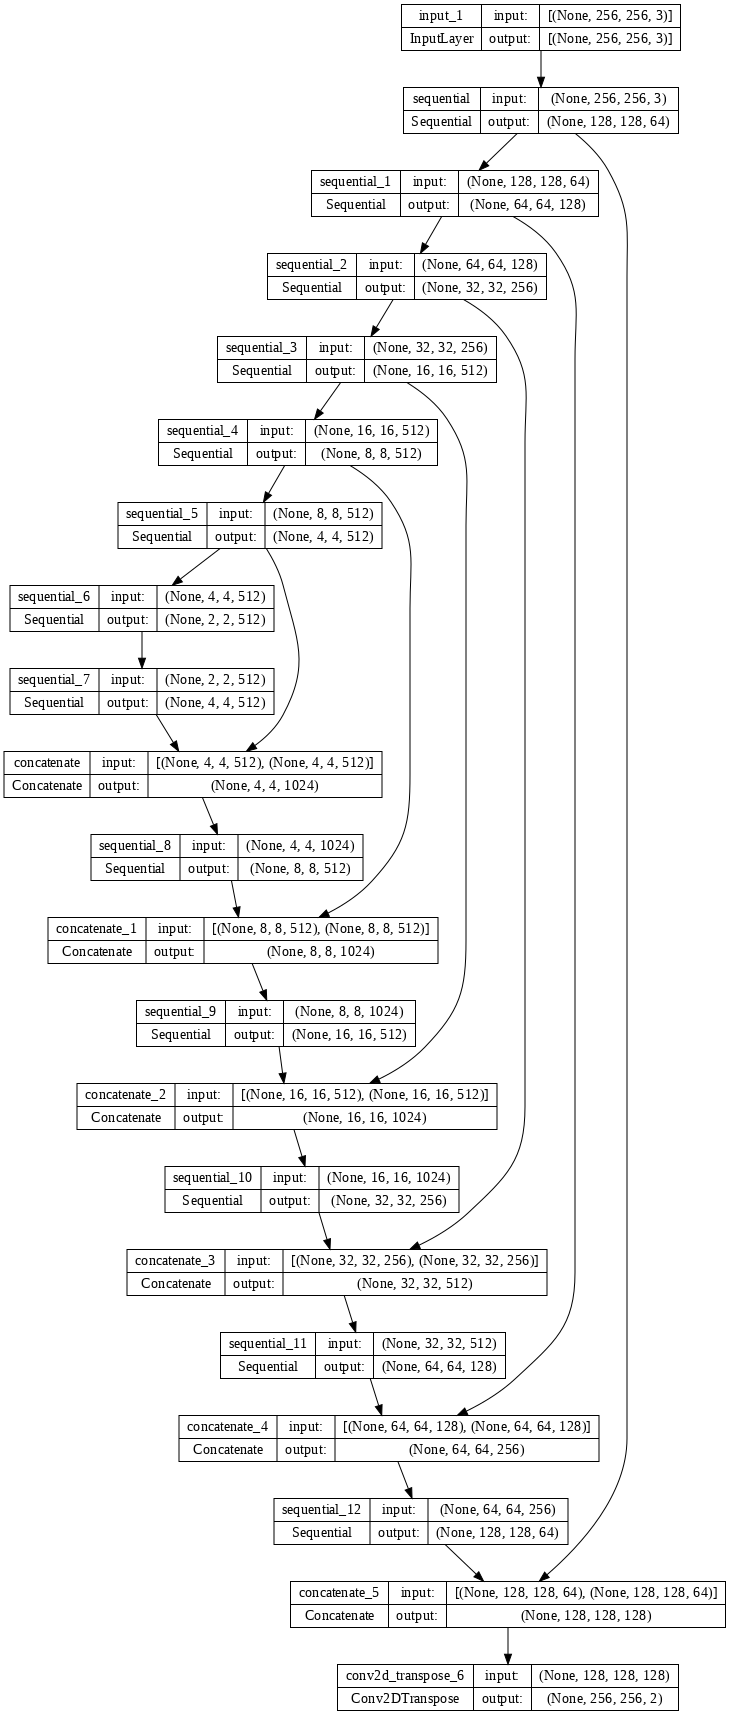

In [ ]:
inp_layer = input_layer()

downsample_stack = [
    downsample_block(64, 4, batch_norm=False),
    downsample_block(128, 4),
    downsample_block(256, 4),
    downsample_block(512, 4),
    downsample_block(512, 4),
    downsample_block(512, 4),
    downsample_block(512, 4),
]

upsample_stack = [
    upsample_block(512, 4, dropout=True),
    upsample_block(512, 4, dropout=True),
    upsample_block(512, 4, dropout=True),
    upsample_block(256, 4),
    upsample_block(128, 4),
    upsample_block(64, 4)
]

out_layer = output_layer(4)

# Реализуем skip connections
x = inp_layer

downsample_skips = []

for block in downsample_stack:
    x = block(x)
    downsample_skips.append(x)
    
downsample_skips = reversed(downsample_skips[:-1])

for up_block, down_block in zip(upsample_stack, downsample_skips):
    x = up_block(x)
    x = tf.keras.layers.Concatenate()([x, down_block])

out_layer = out_layer(x)

unet_like = tf.keras.Model(inputs=inp_layer, outputs=out_layer)

tf.keras.utils.plot_model(unet_like, show_shapes=True, dpi=72)

## Настройка метрик и потерь модели

In [ ]:
def dice_mc_metric(a, b):
    a = tf.unstack(a, axis=3)
    b = tf.unstack(b, axis=3)
    
    dice_summ = 0
    
    for i, (aa, bb) in enumerate(zip(a, b)):
        numenator = 2 * tf.math.reduce_sum(aa * bb) + 1
        denomerator = tf.math.reduce_sum(aa + bb) + 1
        dice_summ += numenator / denomerator
        
    avg_dice = dice_summ / CLASSES
    
    return avg_dice

def dice_mc_loss(a, b):
    return 1 - dice_mc_metric(a, b)

def dice_bce_mc_loss(a, b):
    return 0.3 * dice_mc_loss(a, b) + tf.keras.losses.binary_crossentropy(a, b)

unet_like.compile(optimizer='adam', loss=[dice_bce_mc_loss], metrics=[dice_mc_metric])

## Обучение нейронной сети и сохранение результатов

In [ ]:
history_dice = unet_like.fit(train_dataset, validation_data=test_dataset, epochs=25, initial_epoch=0)

unet_like.save_weights('/content/drive/MyDrive/GRYAZY/DB/modely/unet_like')

Epoch 1/25
125/125 [==============================] - 652s 5s/step - loss: 0.6802 - dice_mc_metric: 0.4473 - val_loss: 1.1195 - val_dice_mc_metric: 0.4159
Epoch 2/25
125/125 [==============================] - 32s 257ms/step - loss: 0.6471 - dice_mc_metric: 0.4514 - val_loss: 0.8417 - val_dice_mc_metric: 0.4284
Epoch 3/25
125/125 [==============================] - 32s 258ms/step - loss: 0.6255 - dice_mc_metric: 0.4625 - val_loss: 1.1564 - val_dice_mc_metric: 0.4225
Epoch 4/25
125/125 [==============================] - 32s 255ms/step - loss: 0.6128 - dice_mc_metric: 0.4707 - val_loss: 0.8324 - val_dice_mc_metric: 0.4408
Epoch 5/25
125/125 [==============================] - 32s 256ms/step - loss: 0.5989 - dice_mc_metric: 0.4783 - val_loss: 0.7437 - val_dice_mc_metric: 0.4632
Epoch 6/25
125/125 [==============================] - 32s 256ms/step - loss: 0.5842 - dice_mc_metric: 0.4859 - val_loss: 0.7672 - val_dice_mc_metric: 0.4663
Epoch 7/25
125/125 [==============================] - 32s 25

## Загрузка модели


In [ ]:
unet_like.load_weights('/content/drive/MyDrive/GRYAZY/DB/modely/unet_like')

## Сама работа сети

In [ ]:
#Выбор массива картинок
frames = sorted(glob.glob('/content/drive/MyDrive/GRYAZY/trys/0/or/*.*'))
#frames = {'/content/drive/MyDrive/GRYAZY/trys/0/or/image_2022-09-05_20-39-26.png'}
#Выбор папки результатов
destdir = '/content/drive/MyDrive/GRYAZY/trys/0/re'
#Цвета обводки
rgb_colors = [
    (0,   0,    0),
    (255, 0,    0)
]

In [ ]:
for filename in frames:
    frame = imread(filename)
    if frame.shape[2] == 4:
      frame = frame[:,:,:3]
    sample = tfa.image.gaussian_filter2d(frame)
    sample = resize(sample, SAMPLE_SIZE)
    predict = unet_like.predict(sample.reshape((1,) +  SAMPLE_SIZE + (3,)))
    predict = predict.reshape(SAMPLE_SIZE + (CLASSES,))
        
    scale = frame.shape[0] / SAMPLE_SIZE[0], frame.shape[1] / SAMPLE_SIZE[1]
    
    frame = (frame / 1.5).astype(np.uint8)
    
    for channel in range(1, CLASSES): 
        contour_overlay = np.zeros((frame.shape[0], frame.shape[1]))
        contours = measure.find_contours(np.array(predict[:,:,channel]))
        
        try:
            for contour in contours:
                rr, cc = polygon_perimeter(contour[:, 0] * scale[0],
                                           contour[:, 1] * scale[1],
                                           shape=contour_overlay.shape)
                
                contour_overlay[rr, cc] = 1        
            
            contour_overlay = dilation(contour_overlay, disk(1))
            frame[contour_overlay == 1] = rgb_colors[channel]
        except:
            pass

    imsave(f'{destdir}/{os.path.basename(filename)}', frame)

1/1 [==============================] - 0s 32ms/step


#

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
